# MNIST Classification Project

MNIST is a dataset that stands for **Modified National Institute of Standards and Technology** dataset. It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

In [ ]:
!pip3 install scikit-learn

In [ ]:
! pip3 show scikit-learn

In [92]:
# Import requirements
import sys
assert sys.version_info >= (3,5)
sys.path.append('/Users/ml/ml_env/lib/python3.8/site-packages')

import sklearn as sk
# assert sklearn.__version__ > "0.20" # Scikit-learn version 0.20 or later is required

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [93]:
# To download to the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- The `DESCR` key describes the dataset
- The `data` key contains an array with one row per instance and one column per feature
- The `target`contains an array with the labels

To read more on the description of the keys, visit the documentation on Scikit-learn's [website](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).

In [94]:
# To view the arrays in the dataset
data, tar = mnist["data"], mnist["target"]

data.shape

(70000, 784)

In [95]:
tar.shape

(70000,)

From the shape of the data, we can infer there are 70000 instances or images, and each image has 784 features. Each image has 28 x 28 pixels, and each feature represents one pixel's intensity, from 0 (white) to 255 (black)

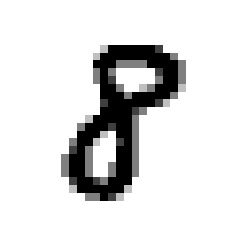

In [96]:
sample_digit = data[245]
sample_digit_img = sample_digit.reshape(28, 28)

plt.imshow(sample_digit_img, cmap="binary")
plt.axis("off")
plt.show()

In [97]:
# The labels are currently in str format, before feeding it to an ML algo, it must be changed to int
tar = tar.astype(np.uint8)

In [98]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [99]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


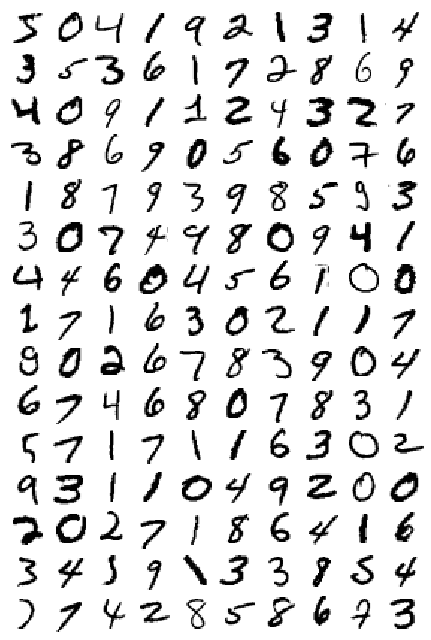

In [100]:
plt.figure(figsize=(9,9))
example_images = data[:150]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

### Splitting the Dataset into Training and Testing set

By default the MNIST dataset is already split by Sklearn. The training set contains the first set of 60000 images, and the test set contains the last 10000 images.

In [101]:
data_train, data_test, label_train, label_test = data[:60000], data[60000:], tar[:60000], tar[60000:]

## Training a Binary Classifier

The binary classifier is going to be trained to recognize one digit; the number 8. The classifier is going to be distinguishing between just two classes, 8 and not 8.

In [102]:
label_train_8 = (label_train == 8) # True for all 8s, False for all other numbers.
label_test_8 = (label_test == 8)

In [103]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(data_train, label_train_8)

SGDClassifier(random_state=42)

In [104]:
sgd_clf.predict([sample_digit])

array([ True])

### Measuring Accuracy Using Cross-Validation

In [105]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(data_train, label_train_8):
    clone_clf = clone(sdg_clf)
    data_train_folds = data_train[train_index]
    label_train_folds = label_train_8[train_index]
    data_test_fold = data_train[test_index]
    label_test_fold = label_train_8[test_index]
    
    clone_clf.fit(data_train_folds, label_train_folds)
    label_pred = clone_clf.predict(data_test_fold)
    n_correct = sum(label_pred == label_test_fold)
    print(n_correct / len(label_pred))

0.9365
0.92665
0.8386


The accuracy of the classifier is 90% (this is the ratio of correct predictions: 0.90). To verify the accuracy for True positive predictions is correct, a classifier that classifies  every single image in the not 8 class if needed, as shown below in the `Not8Classifier` class

In [106]:
from sklearn.base import BaseEstimator
class Not8Classifier(BaseEstimator):
    def fit(self, data, tar=None):
        pass
    def predict(self, data):
        return np.zeros((len(data), 1), dtype=bool)

In [107]:
from sklearn.model_selection import cross_val_score

not_8_clf = Not8Classifier()
cross_val_score(not_8_clf, data_train, label_train_8, cv=3, scoring="accuracy")

array([0.9039 , 0.9031 , 0.90045])

## Measuring Performance using Confusion Matrix

In [108]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

tar_train_pred = cross_val_predict(sgd_clf, data_train, label_train_8, cv=3)
confusion_matrix(label_train_8, tar_train_pred)

array([[50006,  4143],
       [ 1448,  4403]])

In the confusion matrix above, each row is represented by the Actual value and each column is represented by the predicted value. In pos(0,0) and pos(0,1) i.e., the 1st row of the matrix is considered the non-8s images (negative class): 50006 images correctly classified as **_True Negative_** (i.e., pos(0,0)) and 4143 images of the negative class has been labeled positive making them **_False Positives_** (i.e., pos(0,1)). The second row; pos(1,0) and pos(1,1) are considered the images of 8s (Positive class): 1448 images were incorrectly classified as non-8s/negative class (i.e., pos(1,0)) these are **_False Negatives_**, while 4403 images were correctly classified as 8s/positve class (pos[1,1]) these are **_True Positive_**.

In a perfect classifier would have only True positves and True Negatives.

## Precision, Recall and F-Score

To answer the question: Of all postive predictions by the classifier (True Positive and False Positve), how many of the positive predictiions were actually correct? That means they are True Positves. This metric is called the **_Precision_** of the classifier.

Another important performance metric for a classifier is the **_Recall_**, aka **_sensitivity_** or the **_True Positve Rate_**: this is answers the question, what is the ratio of all positive instances that are correctly detected by the classifier

In [109]:
from sklearn.metrics import precision_score, recall_score

precision_score(label_train_8, tar_train_pred)

0.515211794991809

In [110]:
recall_score(label_train_8, tar_train_pred)

0.7525209365920356

In [111]:
# The precision and recall can also be calculated manually

conf_matrix = confusion_matrix(label_train_8, tar_train_pred)

# Precision = TP/TP + FP
precision = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1])
# Recall = TP/TP + FN
recall = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[1,0])

print(f"Precision: {precision_score}\nRecall: {recall_score}")

Precision: <function precision_score at 0x7f8831a4ee50>
Recall: <function recall_score at 0x7f8831a4eee0>


In [112]:
# The F-Score, in this case the F1 score is the harmonic mean of the precision and recall. 
# F1-score = TP / (TP + (FN + FP) / 2)
from sklearn.metrics import f1_score

f1_score(label_train_8, tar_train_pred)

0.611655205945683

In [113]:
# Manually the f1-score can be calculated as follows:

f1 = conf_matrix[1,1] / (conf_matrix[1,1] + (conf_matrix[1,0] + conf_matrix[0,1]) / 2)
print(f"F1-Score: {f1}")

F1-Score: 0.6116552059456831


### Precision vs Recall Trade-off

In [114]:
tar_scores = sgd_clf.decision_function([sample_digit])
tar_scores

array([2966.0209479])

In [115]:
threshold = 0
tar_sample_digit_pred = (tar_scores > threshold)
tar_sample_digit_pred

array([ True])

In [116]:
threshold = 8000
tar_sample_digit_pred = (tar_scores > threshold)
tar_sample_digit_pred

array([False])

In [117]:
clf_scores = cross_val_predict(sgd_clf, data_train, label_train_8, cv=3, method="decision_function")

In [118]:
# Using the clf_scores, we can compute and visualize the precision recall curve to compute the precision and recall
# for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(label_train_8, clf_scores)

Saving figure precision_recall_vs_threshold_plot


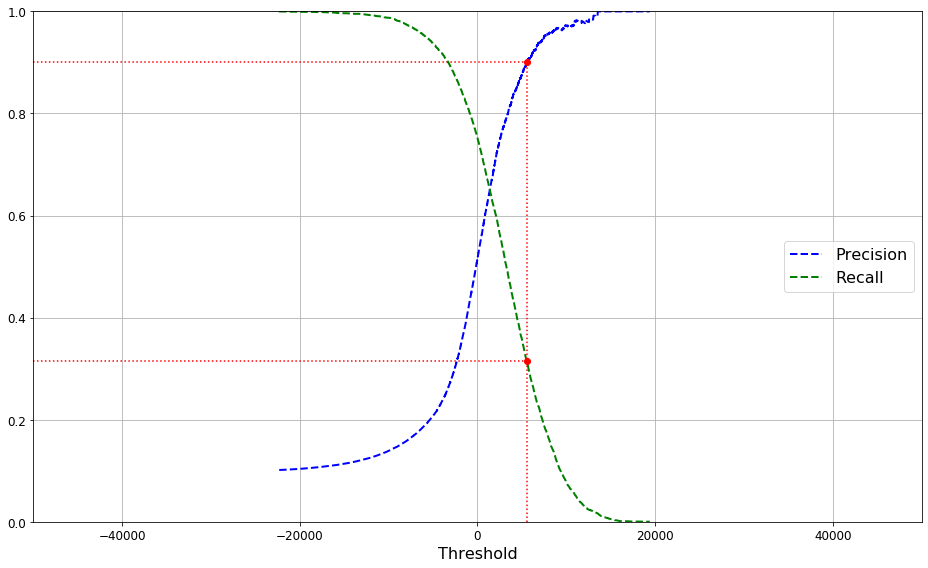

In [119]:
# Plot the visualization for the precision_recall_curve

def precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(13, 8))
precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

From the plot, we can see when precision is 90%, recall drops to below 40%. The threshold value is 8000

In [120]:
(tar_train_pred == (clf_scores > 0)).all()

True

To get a clearer picture of the precision vs recall tradeoff curve, it is better to plot precision directly against the recall

Saving figure Precision_vs_Recall_Curve


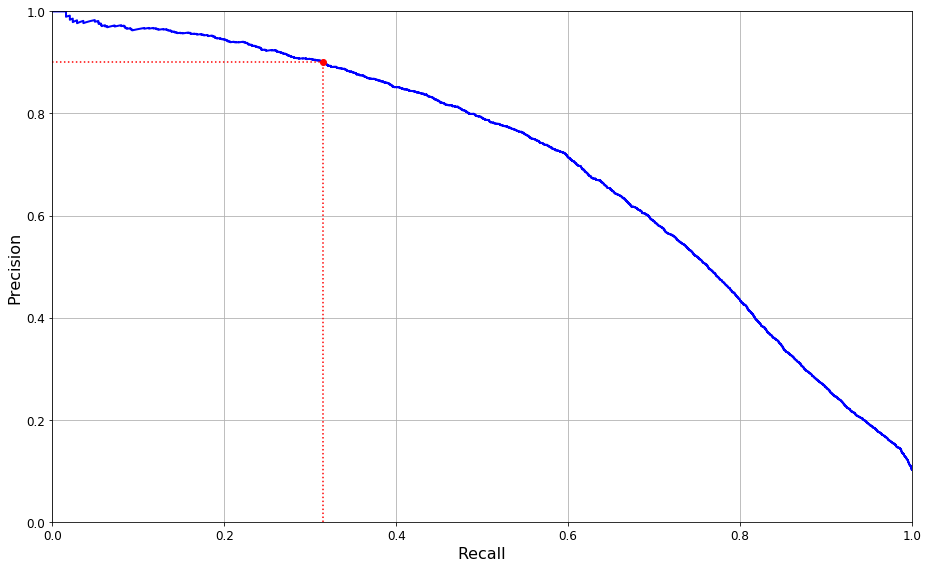

In [121]:
def precision_vs_recall(precisions, recalls):
    """Plots the Precisions against the recall"""
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(13,8))
precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("Precision_vs_Recall_Curve")
plt.show()

As observed in this plot, when compared with the earlier plot `precision_recall_vs_threshold` plot, when the threshold value is raised to 5558.6889, precision is 90% while recall decreases to 31%.

In [122]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

threshold_90_precision

5558.688951079276

In [123]:
tar_train_pred_90 = (clf_scores >= threshold_90_precision)

In [124]:
precision_score(label_train_8, tar_train_pred_90)

0.9003419638495359

In [125]:
recall_score(label_train_8, tar_train_pred_90)

0.3149888907878995

### Receiver Operating Characteristics (ROC) Curve and Area Under the Curve (AUC)

In [126]:
# The ROC curve is similar to the precision-recall curve, but instead of plotting the precision against the recall,
# ROC curve plots the True Positive Rate (TPR) (aka recall / sensitivity) against the False Positive Rate (aka Fallout Rate).
# The FPR is also equal to 1 - True Negative Rate (aka Specificity). Hence ROC is Sensitivity vs 1 - Specificity

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(label_train_8, clf_scores)

Saving figure ROC_Curve_Plot


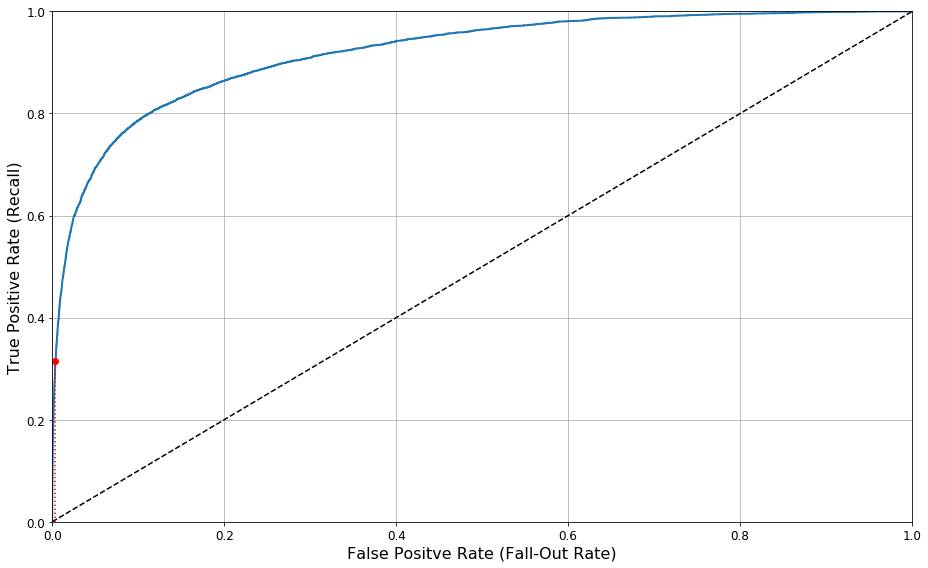

In [127]:
def roc_curve_plot(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positve Rate (Fall-Out Rate)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(13, 8))
roc_curve_plot(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
save_fig("ROC_Curve_Plot")
plt.show()

To compare different classifier models, we use the ROC-AUC. In the code block below, we compare `RandomForestClassifier` ROC and AUC to  **_Stochactic Gradient Descent Classifier_** `SGDClassifier`

In [128]:
from sklearn.metrics import roc_auc_score

roc_auc_score(label_train_8, clf_scores)

0.9192599874103056

Saving figure roc_auc_comparison_plot


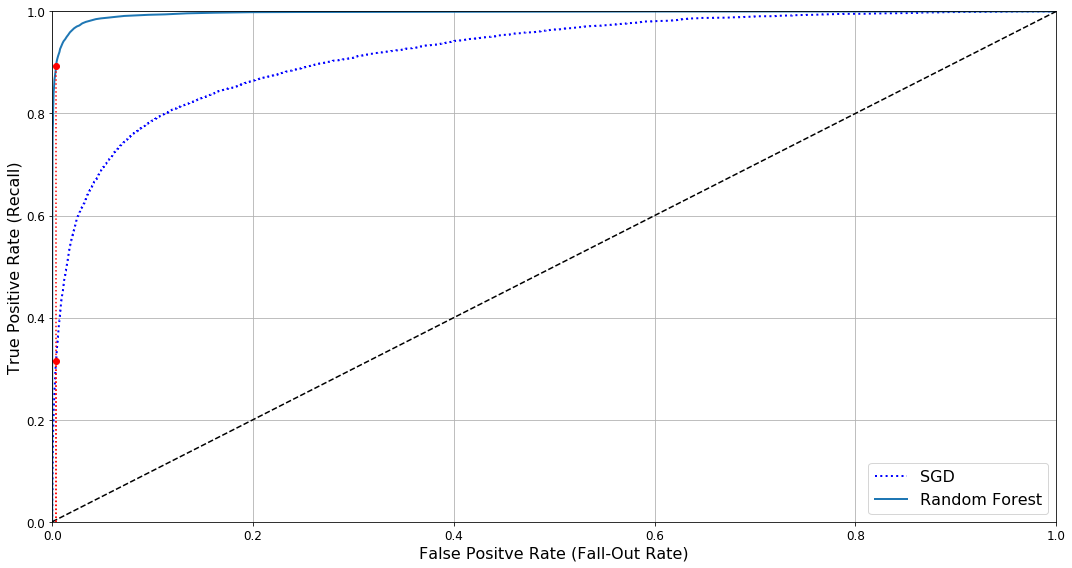

In [129]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
tar_probs_forest = cross_val_predict(forest_clf, data_train, label_train_8, cv=3, method="predict_proba")
tar_scores_forest = tar_probs_forest[:, 1] # score = probality of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(label_train_8, tar_scores_forest)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
roc_curve_plot(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_auc_comparison_plot")
plt.show()

In [131]:
roc_auc_score(label_train_8, tar_scores_forest)

0.9965481456893603

In [135]:
tar_train_pred_forest = cross_val_predict(forest_clf, data_train, label_train_8, cv=3)
precision_score(label_train_8, tar_train_pred_forest)

0.9892834629123766

In [136]:
recall_score(label_train_8, tar_train_pred_forest)

0.8046487779866689

### Multiclass Classification

In [137]:
from sklearn.svm import SVC # SVC Support Vector Classifier

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(data_train[:1000], label_train[:1000]) #label_train, not label_train_8
svm_clf.predict([sample_digit])

array([8], dtype=uint8)

In [138]:
# Under the hood, SKlearn used One vs One (OvO) approach. Training 45 binary classifiers, got their decision scores
# for the images, and selected the class that had the highest probability 
# Using the decision_function() method, 10 scores per instance is returned, one for each class. The highest score is the one corresponding to the figure 8

sample_digit_scores = svm_clf.decision_function([sample_digit])
sample_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
        -0.21097847,  1.79862509,  8.10392157,  9.29534457,  4.83753243]])

In [139]:
np.argmax(sample_digit_scores)

8

In [140]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

N.B: When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value.

In [141]:
# To force Sklearn to use the One-vs-the Rest strategy

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(data_train[:1000], label_train[:1000])
ovr_clf.predict([sample_digit])

array([8], dtype=uint8)

In [142]:
len(ovr_clf.estimators_)

10

In [143]:
# Training an SGDClassifier is easy, since SKlearn did not have to run an OvO or OvR because SGDClf can directly classify instances into multiple classes
sgd_clf.fit(data_train, label_train)
sgd_clf.predict([sample_digit])

array([8], dtype=uint8)

In [144]:
sgd_clf.decision_function([sample_digit])

array([[-29941.25105295, -16016.67252461,  -7156.53886604,
         -1859.13126663, -15966.40641118,  -7085.81903099,
        -31372.91321323, -27433.29936798,   4010.55850994,
         -9685.62336248]])

In [145]:
cross_val_score(sgd_clf, data_train, label_train, cv=3, scoring="accuracy") 

# array([0.87365, 0.85835, 0.8689 ]) Accuracy is over 85% on all test folds

array([0.87365, 0.85835, 0.8689 ])

In [146]:
# Scaling inputs can net us better accuracy

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train.astype(np.float64))
cross_val_score(sgd_clf, data_train_scaled, label_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [147]:
tar_train_pred = cross_val_predict(sgd_clf, data_train_scaled, label_train, cv=3)
conf_matrix = confusion_matrix(label_train, tar_train_pred)
conf_matrix

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [148]:
def conf_matrix_plot(matrix):
    """Plot an image representation of the confusion matrix"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_visualization


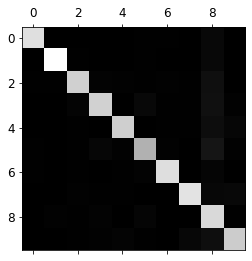

In [149]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
save_fig("confusion_matrix_visualization", tight_layout=False)
plt.show()

To plot the errors, we divide each value in the confusion matrix by the number of images in the corresponding class. This allows for the comparison of the error rates rather than absolute number of errors (abdundant classses may be exaggerated.

In [150]:
sum_rows = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / sum_rows

Saving figure confusion_matrix_errors_plot


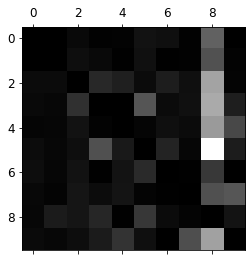

In [151]:
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


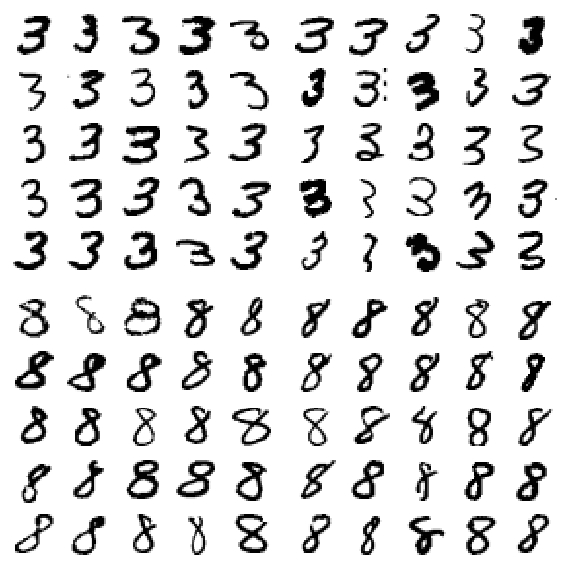

In [153]:
cl_a, cl_b = 3, 8
data_aa = data_train[(label_train == cl_a) & (tar_train_pred == cl_a)]
data_ab = data_train[(label_train == cl_a) & (tar_train_pred == cl_b)]
data_ba = data_train[(label_train == cl_b) & (tar_train_pred == cl_a)]
data_bb = data_train[(label_train == cl_b) & (tar_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(data_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(data_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(data_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(data_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

The two 5x5 blocks on the left show digits classified as 3s, and the other two 5x5 blocks on the right show images classified as 8s. In the bottom-left and top-right blocks are the digits the classifier gets wrong due to the some digit being so badly written.

### Multilabel Classification

In [154]:
from sklearn.neighbors import KNeighborsClassifier

label_train_large = (label_train >= 5) # Target label indicates whether an image is large (5, 6, 7, 8)
label_train_odd = (label_train % 2 == 1) # Target label indicates that the digit in the image is an odd number

tar_multilabel = np.c_[label_train_large, label_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(data_train, tar_multilabel)

KNeighborsClassifier()

In [155]:
knn_clf.predict([sample_digit])
#Returns an array [True, False]. The True boolean indicates that the sample digit, 8, passed as input is > 5 satisfying the 1st condition
# The False boolean indicate that 8 is not an odd number

array([[ True, False]])

In [156]:
# To get the accuracy of the KNN classififier
tar_train_knn_pred = cross_val_predict(knn_clf, data_train, tar_multilabel, cv=3)
f1_score(tar_multilabel, tar_train_knn_pred, average="macro")

0.9817475061789299

In [162]:
# To Test KNN Clasifier on the test data
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=4)
knn_clf.fit(data_train, label_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [163]:
tar_knn_pred = knn_clf.predict(data_test)

In [165]:
from sklearn.metrics import accuracy_score

accuracy_score(label_test, tar_knn_pred)

0.9714

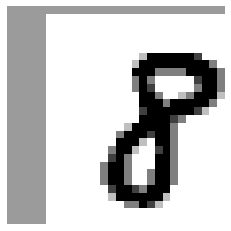

In [166]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(sample_digit, 5, 1, new=100))

In [170]:
data_train_expanded = [data_train]
label_train_expanded = [label_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=data_train, dx=dx, dy=dy)
    data_train_expanded.append(shifted_images)
    label_train_expanded.append(label_train)

data_train_expanded = np.concatenate(data_train_expanded)
label_train_expanded = np.concatenate(label_train_expanded)
data_train_expanded.shape, label_train_expanded.shape

((300000, 784), (300000,))

In [171]:
knn_clf.fit(data_train_expanded, label_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [172]:
tar_knn_expanded_pred = knn_clf.predict(data_test)

In [173]:
accuracy_score(label_test, tar_knn_expanded_pred)

0.9763

In [176]:
ambiguous_digit = data_test[3000]
knn_clf.predict_proba([ambiguous_digit])

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

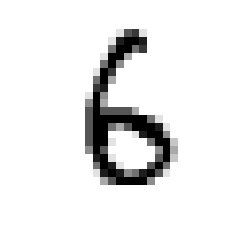

In [177]:
plot_digit(ambiguous_digit)

## Multioutput Classification

In [178]:
# The system below removes noise from the images. It takes the input as a noisy image, denoises it, and outputs a clearer image

noise = np.random.randint(0, 100, (len(data_train), 784))
data_train_mod = data_train + noise # Adds noise to image pixels. The target image is the original image
noise = np.random.randint(0, 100, (len(data_test), 784))
data_test_mod = data_test + noise
label_train_mod = data_train
label_test_mod = data_test

Saving figure noisy_digit_example_plot


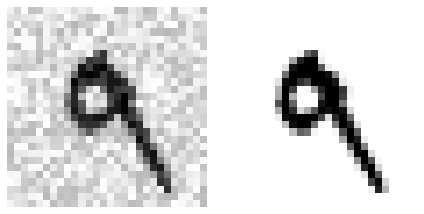

In [180]:
sample_index = 7
plt.subplot(121); plot_digit(data_test_mod[sample_index])
plt.subplot(122); plot_digit(label_test_mod[sample_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


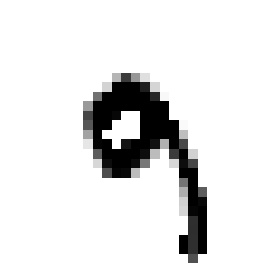

In [181]:
knn_clf.fit(data_train_mod, label_train_mod)
clean_digit = knn_clf.predict([data_test_mod[sample_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

In [182]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
tar_probas_dmy = cross_val_predict(dmy_clf, data_train, label_train_8, cv=3, method="predict_proba")
tar_scores_dmy = tar_probas_dmy[:, 1]

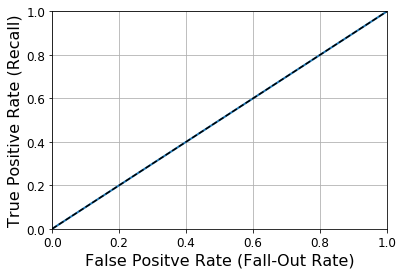

In [184]:
fprr, tprr, thresholdsr = roc_curve(label_train_8, tar_scores_dmy)
roc_curve_plot(fprr, tprr)

In [187]:
# Training classifier using KNN Classifier and GridSearch hyperparamters

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["distance", "uniform"], 'n_neighbors': [3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(data_train, label_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  10.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  10.0s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  10.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  12.6s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=   9.9s
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  11.9s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  10.3s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  10.3s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  10.4s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  11.1s
[CV 1/5] END ...n_neighbors=4, weights=distance;, score=0.973 total time=  13.1s
[CV 2/5] END ...n_neighbors=4, weights=distance;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['distance', 'uniform']}],
             verbose=3)

In [188]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [192]:
grid_search.best_score_

0.9716166666666666

In [193]:
from sklearn.metrics import accuracy_score

tar_pred = grid_search.predict(data_test)
accuracy_score(label_test, tar_pred)

0.9714

## Training Set Expansion and Data Augmentation

In [194]:
from scipy.ndimage.interpolation import shift

In [195]:
def shift_img(img, dx, dy): # img is the image index, dx is the direction in the x-axis (left or right), dy is the direction in the y-axis (up or down)
    """Function allows for an image to be shifted in any direction"""
    img = img.reshape(28, 28)
    shifted_img = shift(img, [dy, dx], cval=0, mode="constant")
    return shifted_img.reshape([-1])

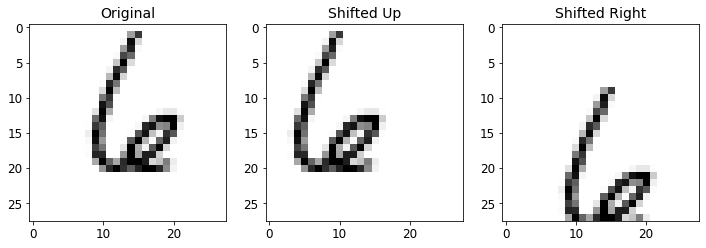

In [197]:
image = data_train[536]
shifted_img_up = shift_img(image, -5, 0)
shifted_img_right = shift_img(image, 0, 8)

plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28,28), interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("Shifted Up", fontsize=14)
plt.imshow(shifted_img_up.reshape(28,28), interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("Shifted Right", fontsize=14)
plt.imshow(shifted_img_right.reshape(28,28), interpolation="nearest", cmap="Greys")

plt.show()

In [198]:
data_train_augmented = [image for image in data_train]
label_train_augmented = [image for image in label_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(data_train, label_train):
        data_train_augmented.append(shift_img(image, dx, dy))
        label_train_augmented.append(label)
        
data_train_augmented = np.array(data_train_augmented)
label_train_augmented = np.array(label_train_augmented)

In [199]:
shuffle_indx = np.random.permutation(len(data_train_augmented))
data_train_augmented = data_train_augmented[shuffle_indx]
label_train_augmented = label_train_augmented[shuffle_indx]

In [200]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [201]:
knn_clf.fit(data_train_augmented, label_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [202]:
tar_pred = knn_clf.predict(data_test)
accuracy_score(label_test, tar_pred)

# Output 0.9763, a plus 0.5% increase in accuracy after data augmentation

0.9763